In [1]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, cohen_kappa_score
from ast import literal_eval
from sklearn.metrics.pairwise import linear_kernel
import warnings
warnings.filterwarnings("ignore")

In [2]:
nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adel_El_Nabarawy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Adel_El_Nabarawy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Adel_El_Nabarawy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Preparation

In [3]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(12,15))
    ax = sns.barplot(data=d, x= "count", y = "word")
    ax.set(ylabel = 'Word')
    plt.show()

In [4]:
#cleaning book data from stop words and punctuation
def wordPreparation(txt, flg_stemm=False, flg_lemm=True):
    tokenized_word = nltk.word_tokenize(txt)
    tokenized_word = nltk.RegexpTokenizer('\w+').tokenize(txt)
    stop_words=set(stopwords.words("english"))
  
  ## Removing stop words and punctuation 
    filtered_words=[x.lower() for x in tokenized_word if x.lower() not in stop_words and x.isalnum() ]
    
  
  ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in filtered_words]
              
  ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in filtered_words]

    filtered_words = " ".join(filtered_words)
    return filtered_words

In [5]:
df = pd.read_csv('IMDB_Top250Engmovies2_OMDB_Detailed.csv')
df = df.sample(frac=1).reset_index(drop=True)
# to combine 4 lists (4 columns) of key words into 1 sentence under Bag_of_words column
df['details'] = df['Genre']+' '+df['Director']+' '+df['Actors']+' '+df['Plot']
final_data = pd.DataFrame({'label':range(0,250),'title':df['Title'],'details':df['details']})
final_data['details'] = final_data['details'].apply(wordPreparation)
X = final_data['details'] 
y = final_data['title']
final_data

,label,title,details
0,0,Sin City,crime thriller frank miller robert rodriguez q...
1,1,Sleuth,mystery thriller joseph l mankiewicz laurence ...
2,2,The Gold Rush,adventure comedy drama charles chaplin charles...
3,3,Up,animation adventure comedy pete docter bob pet...
4,4,Hotel Rwanda,biography drama history terry george cheadle x...
...,...,...,...
245,245,High Noon,drama thriller western fred zinnemann gary coo...
246,246,Stand by Me,adventure drama rob reiner wil wheaton river p...
247,247,Cat on a Hot Tin Roof,drama romance richard brooks elizabeth taylor ...
248,248,Schindler's List,biography drama history steven spielberg liam ...


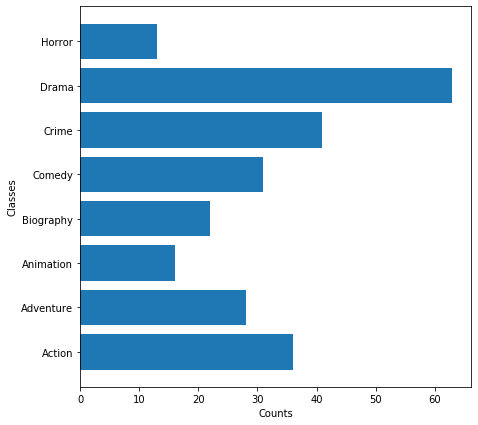

In [6]:
def MapTrueClusterClass(y_true_, y_pred_):
    clus_true_class = []
    clus_true_lab = dict()
    for pred in set(y_pred_):
        cluster_members = y_true_[pred == y_pred_]
        clus, clus_counts = np.unique(cluster_members, return_counts = True)
        dom_class = clus[np.argmax(clus_counts)]
        clus_true_lab[pred] = dom_class
        clus_true_class.append(dom_class)
    # End For
    return clus_true_class, clus_true_lab
# End Func

temp_gen = [genre.split(',') for genre in df['Genre']]
genres = np.array([genre.split(',')[0] for genre in df['Genre']])
final_data['MGenre'] = genres
final_data['Genres'] = temp_gen

for val in ['Mystery', 'Film-Noir', 'Sci-Fi']:
    genres[genres == val] = 'Horror'
# End For

classes, counts = np.unique(genres, return_counts=True)
classes_inds = { i: classes[i]  for i in range(len(classes)) }
y_clusters = np.array([[k for k, v in classes_inds.items() if v == val][0] for val in genres])
plt.figure(figsize=(7, 7))
plt.barh(classes, counts)
plt.xlabel('Counts')
plt.ylabel('Classes')
plt.show()

In [7]:
tfidf_vec = TfidfVectorizer()
X_tfidf = tfidf_vec.fit_transform(X)

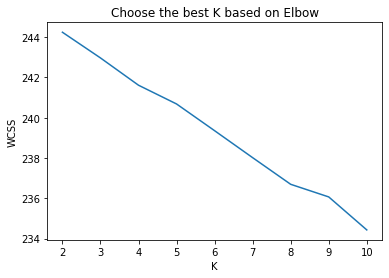

In [8]:
wcss = []
sillou = []
ks = []

for i in range(1, 10):
    k = i+1
    model_ = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
    y_pred = model_.fit(X_tfidf).predict(X_tfidf)
    cluster_labels, _ = MapTrueClusterClass(y_clusters, y_pred)
    true_cluster_labels = [cluster_labels[pred] for pred in y_pred]
    
    sillou.append(silhouette_score(np.array(true_cluster_labels).reshape(-1, 1), np.array(y_clusters).reshape(-1, 1)))
    ks.append(k)
    wcss.append(model_.inertia_)
# End of For

plt.plot(ks, wcss)
plt.title('Choose the best K based on Elbow')
plt.xlabel('K')
plt.ylabel('WCSS')
plt.show()

In [9]:
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
y_pred = model.fit(X_tfidf).predict(X_tfidf)
cluster_labels, clusters_dom_class = MapTrueClusterClass(y_clusters, y_pred)
true_cluster_labels = [cluster_labels[pred] for pred in y_pred]
print('wcss: ', model.inertia_)
print('silhouette: ', silhouette_score(np.array(true_cluster_labels).reshape(-1, 1), np.array(y_clusters).reshape(-1, 1)))
print('kappa: ',  cohen_kappa_score(np.array(true_cluster_labels).reshape(-1, 1), np.array(y_clusters).reshape(-1, 1)))

wcss:  239.28173897657496
silhouette:  -0.23608284881338643
kappa:  0.19771105998801397


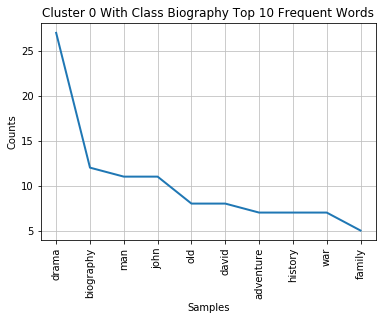

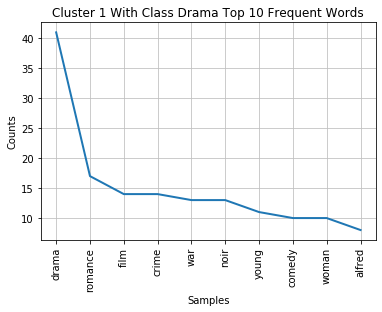

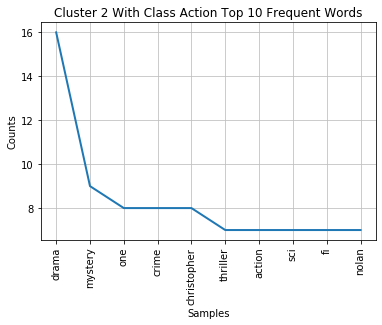

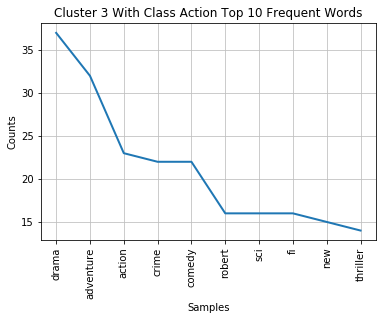

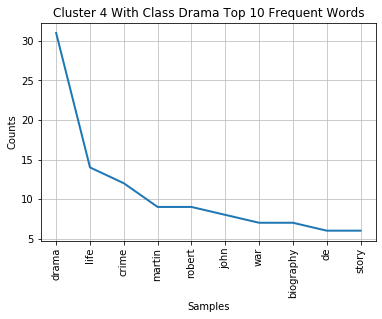

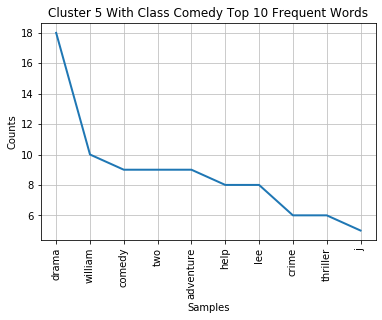

In [10]:
# Top 10 frequent word in each cluster
def plt_top(clus_texts, title = '', num = 10):
    clus_texts = ' '.join(clus_texts)
    plt.title(title)
    nltk.FreqDist(nltk.word_tokenize(clus_texts)).plot(num)
    plt.show()
# End of Func

def AnalyseText(txt_):
    print(f'text: {txt_}')
    nltk.FreqDist(nltk.word_tokenize(txt_)).plot()
    plt.show()
# End of Func

for clus_num in range(true_k):
    plt_top(X[y_pred == clus_num], title = f'Cluster {clus_num} With Class {classes_inds[clusters_dom_class[clus_num]]} Top {10} Frequent Words', num=10)
# End of For

In [11]:
tsne = TSNE(n_components=2,random_state=100)
data2D = tsne.fit_transform(X_tfidf)

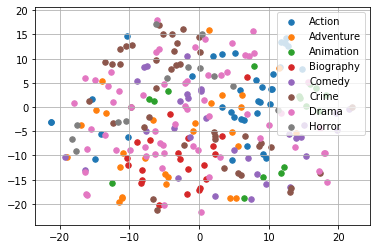

In [12]:
fig, ax = plt.subplots()
for cls in classes:
    ax.scatter(data2D[cls == genres, 0], data2D[cls == genres, 1],s=30 ,label=cls)
# End Of For
ax.legend()
ax.grid(True)

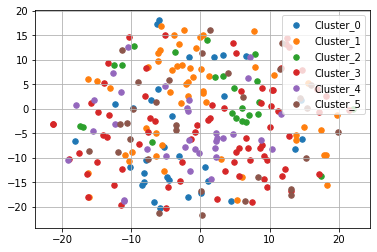

In [13]:
fig, ax = plt.subplots()
for pred in range(0, true_k):
    ax.scatter(data2D[pred == y_pred, 0], data2D[pred == y_pred, 1],s=30 ,label=f'Cluster_{pred}')
# End Of For
ax.legend()
ax.grid(True)

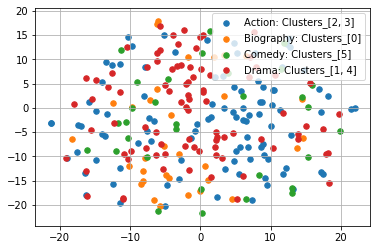

In [14]:
fig, ax = plt.subplots()
for lbl in set(true_cluster_labels):
    inds = [i for i in range(len(cluster_labels)) if cluster_labels[i] == lbl]
    ax.scatter(data2D[lbl == true_cluster_labels, 0], data2D[lbl == true_cluster_labels, 1],s=30 ,label=f'{classes_inds[lbl]}: Clusters_{inds}')
# End Of For
ax.legend()
ax.grid(True)

In [15]:
# wordPreparation()
trans = tfidf_vec.transform(['I want a shooting and action film events'])
pred_ = model.predict(trans)
cosine_similarities = linear_kernel(trans[0:1], X_tfidf[pred_ == y_pred]).flatten()
final_df = pd.DataFrame()
final_df['film'] = y[pred_ == y_pred]
final_df['score'] = cosine_similarities
final_df = final_df.sort_values(by = ['score'], ascending=False)
print(f"The predicted cluster is {pred_[0]} which is type {classes_inds[cluster_labels[pred_[0]]]}")
final_df.head(10).reset_index().drop('index', axis=1)

The predicted cluster is 1 which is type Drama


,film,score
0,Sunset Boulevard,0.150835
1,"Lock, Stock and Two Smoking Barrels",0.108251
2,Laura,0.088636
3,The Killing,0.085218
4,The Lost Weekend,0.083814
5,Notorious,0.082584
6,Dial M for Murder,0.081716
7,The Maltese Falcon,0.078331
8,Touch of Evil,0.077223
9,The Big Sleep,0.076174


In [16]:
recommended_films = final_df['film'].head(5).values
recommended_films

array(['Sunset Boulevard', 'Lock, Stock and Two Smoking Barrels', 'Laura',
       'The Killing', 'The Lost Weekend'], dtype=object)

In [17]:
final_df['film'].head(5).index

Int64Index([61, 59, 190, 116, 20], dtype='int64')

### Error Analysis

In [18]:
recommended_discriptions = final_df['film'].head(5).index
final_data.iloc[recommended_discriptions, :].drop('label', axis=1)

,title,details,MGenre,Genres
61,Sunset Boulevard,drama film noir billy wilder william holden gl...,Drama,"[Drama, Film-Noir]"
59,"Lock, Stock and Two Smoking Barrels",comedy crime guy ritchie jason flemyng dexter ...,Comedy,"[Comedy, Crime]"
190,Laura,drama film noir mystery otto preminger gene ti...,Drama,"[Drama, Film-Noir, Mystery]"
116,The Killing,crime drama film noir stanley kubrick sterling...,Crime,"[Crime, Drama, Film-Noir]"
20,The Lost Weekend,drama film noir billy wilder ray milland jane ...,Drama,"[Drama, Film-Noir]"


text: drama film noir billy wilder william holden gloria swanson erich von stroheim nancy olson screenwriter hired rework faded silent film star script find developing dangerous relationship


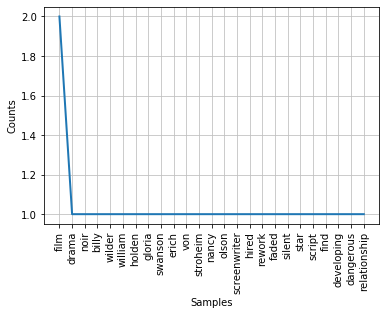

text: comedy crime guy ritchie jason flemyng dexter fletcher nick moran jason statham botched card game london triggers four friends thugs weed growers hard gangsters loan sharks debt collectors collide series unexpected events sake weed cash two antique shotguns


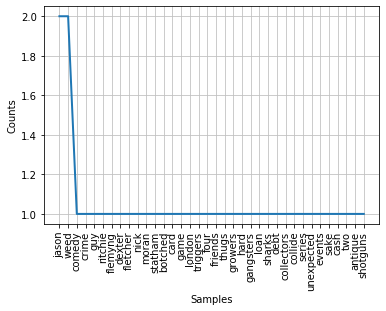

text: drama film noir mystery otto preminger gene tierney dana andrews clifton webb vincent price police detective falls love woman whose murder investigating


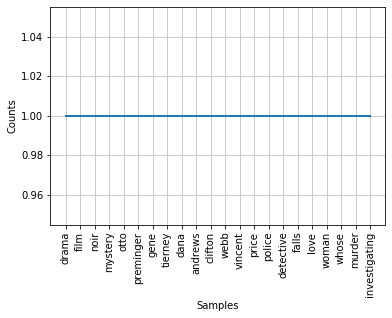

text: crime drama film noir stanley kubrick sterling hayden coleen gray vince edwards jay c flippen crooks plan execute daring race track robbery


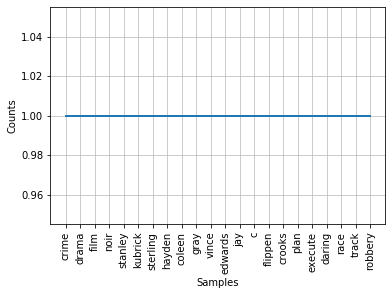

text: drama film noir billy wilder ray milland jane wyman phillip terry howard da silva desperate life chronic alcoholic followed four day drinking bout


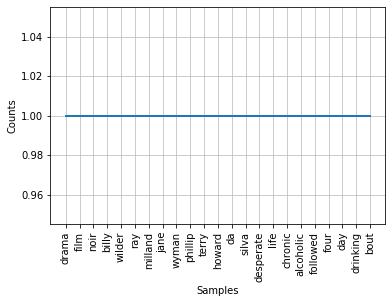

61     None
59     None
190    None
116    None
20     None
Name: details, dtype: object

In [19]:
final_data.iloc[recommended_discriptions, :]['details'].apply(AnalyseText)